## Optimal Order Execution Region (spread long-short regions) and Trading Backtest

entering short at: 186.16
exiting short with growth: 8.757375708360115%, at: 171.17, total_value: 108.7573757083601
entering long at: 171.17
exiting long with growth: 13.343459718408617%, at: 194.01000000000002, total_value: 123.26937232680346
entering short at: 194.01000000000002
exiting short with growth: -1.2922920376494347%, at: 196.54999999999998, total_value: 121.67637204336374
entering long at: 196.54999999999998
exiting long with growth: 13.024675655049602%, at: 222.14999999999998, total_value: 137.52432485084333
entering short at: 222.14999999999998
exiting short with growth: 9.525218162993637%, at: 202.82999999999998, total_value: 150.62381682007023
entering long at: 202.82999999999998
exiting long with growth: 9.470985554405171%, at: 222.04, total_value: 164.8893767525928
entering short at: 222.04
exiting short with growth: 5.157470992185644%, at: 211.15, total_value: 173.39349852780347
entering long at: 211.15
exiting long with growth: 10.580156286999765%, at: 233.49, total

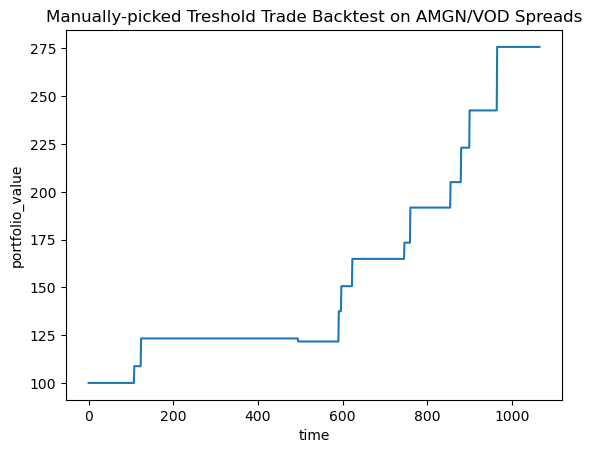

In [144]:
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# We define a backtesting method, that takes
# long-short tresholds and performs a backtest
# this is an oversimplified model that doesn't
# factor in the parameters of the underlying OU
# process and simply trades off arbitrarily
# defined tresholds, this follows an unoptimized
# P/L, which we will later optimize for risk
# appetite or optimality

TEST_SET_END = 1450
DATA_BASE = '../data/nasdaq/'
TICKER_BASE = 'AMGN'
TICKER_AUX = 'VOD'

base_path = os.path.join(DATA_BASE, TICKER_BASE + '.pkl')
aux_path = os.path.join(DATA_BASE, TICKER_AUX + '.pkl')

base = pd.read_pickle(base_path)
aux = pd.read_pickle(aux_path)
spreads = base - aux

def backtest(treshold_down: float, treshold_up: float):
    train_set_spreads = spreads[0:TEST_SET_END]
    
    test_set_spreads = spreads[TEST_SET_END:]
    test_set_len = len(test_set_spreads)
    
    # perform OLS fitting to X_{t} = \beta Y_{t} + \alpha
    x = list(range(len(train_set_spreads)))
    y = train_set_spreads[0]

    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    res = model.fit()

    slope = res.params['x1']
    intercept = res.params['const']

    # perform backtest trading off tresholds
    total_value = 100
    portfolio_values = []

    entered_long = False
    long_entrance_price = 0

    entered_short = False
    short_entrance_price = 0

    enters_long = []
    enters_short = []

    for i in range(test_set_len):
        value = test_set_spreads.iloc[i, 0]

        real_time = TEST_SET_END + i
        pred_value = intercept + (slope * real_time)

        if pred_value + treshold_up < value:
            # End long position on spread
            if entered_long:
                entered_long = False
                growth = (value - long_entrance_price) / long_entrance_price
                total_value *= 1 + growth
                long_entrance_price = 0

                print(f'exiting long with growth: {growth * 100}%, at: {value}, total_value: {total_value}')   

            # short spread
            if not entered_short:
                entered_short = True
                short_entrance_price = value

                enters_short.append(i)
                print(f'entering short at: {value}')

        elif pred_value + treshold_down > value:
            # End short position on spread
            if entered_short:
                entered_short = False
                growth = (short_entrance_price - value) / value
                total_value *= 1 + growth
                short_entrance_price = 0

                print(f'exiting short with growth: {growth * 100}%, at: {value}, total_value: {total_value}')

            # long-spread
            if not entered_long:
                entered_long = True
                long_entrance_price = value

                enters_long.append(i)
                print(f'entering long at: {value}')

        portfolio_values.append(total_value)

    print(f'total startegy value: {total_value}')
    return portfolio_values, enters_long, enters_short


TRADE_DOWN = -10
TRADE_UP = 6

portfolio, long_entrances, short_entrances = backtest(TRADE_DOWN, TRADE_UP)
portfolio_df = pd.DataFrame({
    'time': range(len(portfolio)),
    'portfolio_value': portfolio
})

plt.title('Manually-picked Treshold Trade Backtest on AMGN/VOD Spreads')
sns.lineplot(data=portfolio_df, x='time', y='portfolio_value')
plt.show()

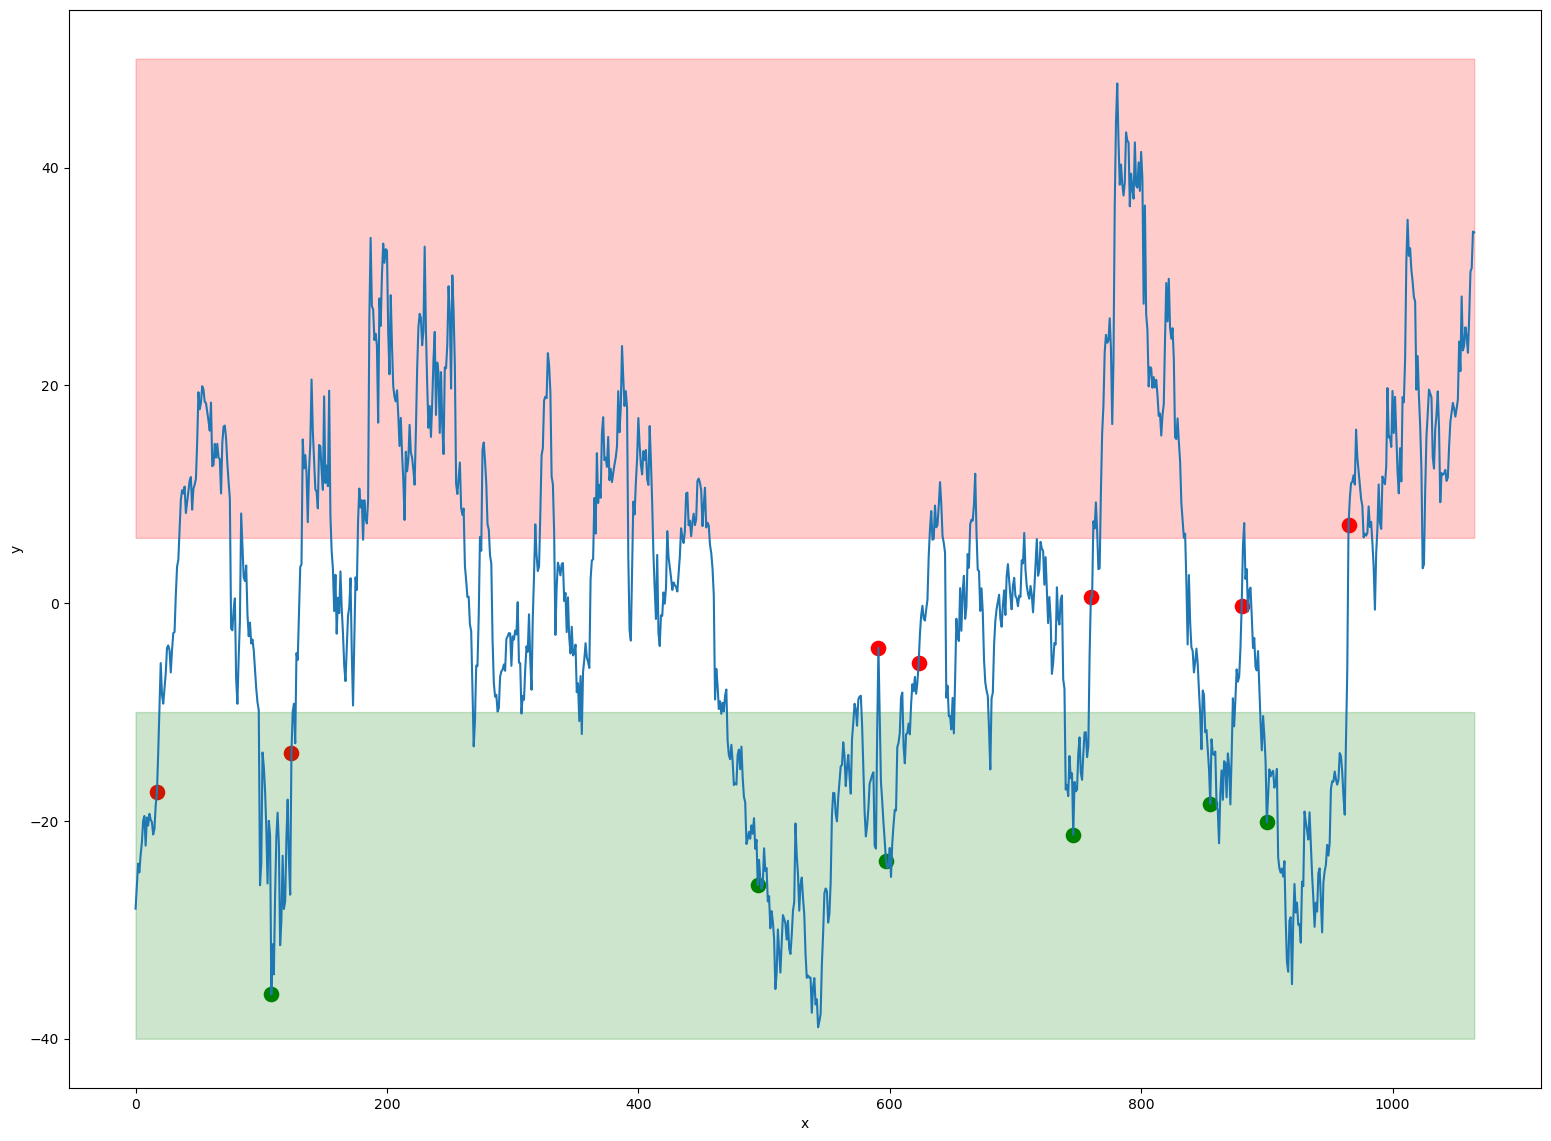

In [145]:
# visualize trade entrance and exit values

spreads = spreads[TEST_SET_END:]
x = range(len(spreads))
y = spreads[0]

x = sm.add_constant(x)
model = sm.OLS(y, x)
res = model.fit()

residuals = res.resid
residuals_df = pd.DataFrame({
    'x': range(len(spreads)),
    'y': residuals
})

long_x = []
long_y = []

short_x = []
short_y = []

for x in long_entrances:
    y = residuals_df.iloc[x, 1]
    long_x.append(x)
    long_y.append(y)

for x in short_entrances:
    y = residuals_df.iloc[x, 1]
    short_x.append(x)
    short_y.append(y)

long_df = pd.DataFrame({
    'x': long_x,
    'y': long_y
})

short_df = pd.DataFrame({
    'x': short_x,
    'y': short_y
})

plt.figure(figsize=(19, 14))

ax = sns.lineplot(data=residuals_df, x='x', y='y')
sns.scatterplot(data=long_df, x='x', y='y', color='green', s=150)
sns.scatterplot(data=short_df, x='x', y='y', color='red', s=150)

ax.fill_between(
    residuals_df['x'],
    TRADE_DOWN,
    -40,
    alpha=0.2,
    color='green'
)

ax.fill_between(
    residuals_df['x'],
    TRADE_UP,
    50,
    alpha=0.2,
    color='red'
)

plt.show()